In [33]:
import os
import datetime
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, length, when, col, broadcast
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField, DateType, BooleanType
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from collections import Counter

from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pylab as plt

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [35]:
df = spark.read.parquet(r"alfabattle2_train_transactions_contest\train_transactions_contest\part_000_0_to_23646.parquet")

In [36]:
# df = spark.read.csv("new_results.csv", header=True, inferSchema=True).persist(StorageLevel.DISK_ONLY)

## Разведочный анализ

### Просмотр данных

In [128]:
df.show(5)

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [38]:
df[
 'app_id',
 'amnt',
 'currency',
 'operation_kind',
 'card_type',
 'operation_type',
 'operation_type_group',
 'ecommerce_flag',
 'payment_system',
 'income_flag',
 'mcc',
 'country',
 'city',
 'mcc_category',
 'day_of_week',
 'hour',
 'days_before',
#  'weekofyear',
#  'hour_diff',
#  'transaction_number',
].show()

+------+-------------------+--------+--------------+---------+--------------+--------------------+--------------+--------------+-----------+---+-------+----+------------+-----------+----+-----------+
|app_id|               amnt|currency|operation_kind|card_type|operation_type|operation_type_group|ecommerce_flag|payment_system|income_flag|mcc|country|city|mcc_category|day_of_week|hour|days_before|
+------+-------------------+--------+--------------+---------+--------------+--------------------+--------------+--------------+-----------+---+-------+----+------------+-----------+----+-----------+
|     0| 0.4654254330729043|       1|             4|       98|             4|                   2|             3|             7|          3|  2|      1|  37|           2|          4|  19|        351|
|     0|                0.0|       1|             2|       98|             7|                   1|             3|             7|          3|  2|      1|  49|           2|          4|  20|        351|


### Типы колонок

In [39]:
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- amnt: double (nullable = true)
 |-- currency: integer (nullable = true)
 |-- operation_kind: integer (nullable = true)
 |-- card_type: integer (nullable = true)
 |-- operation_type: integer (nullable = true)
 |-- operation_type_group: integer (nullable = true)
 |-- ecommerce_flag: integer (nullable = true)
 |-- payment_system: integer (nullable = true)
 |-- income_flag: integer (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- country: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- mcc_category: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- days_before: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- hour_diff: long (nullable = true)
 |-- transaction_number: integer (nullable = true)
 |-- __index_level_0__: long (nullable = true)



* app_id - Идентификатор заявки. заявки пронумерованы так, что более поздним заявкам соответствует более поздняя дата
* amnt - Нормированная сумма транзакции. 0.0 - соответствует пропускам
* currency - Идентификатор валюты транзакции
* operation_kind - Идентификатор типа транзакции
* card_type - Уникальный идентификатор типа карты
* operation_type - Идентификатор типа операции по пластиковой карте
* operationtypegroup - Идентификатор группы карточных операций, например, дебетовая карта или кредитная карта
* ecommerce_flag - Признак электронной коммерции
* payment_system - Идентификатор типа платежной системы
* income_flag - Признак списания/внесения денежных средств на карту
* mcc - Уникальный идентификатор типа торговой точки
* country - Идентификатор страны транзакции
* city - Идентификатор города транзакции
* mcc_category - Идентификатор категории магазина транзакции
* dayofweek - День недели, когда транзакция была совершена
* hour - Час, когда транзакция была совершена
* days_before - Количество дней до даты выдачи кредита
* weekofyear - Номер недели в году, когда транзакция была совершена
* hour_diff - Количество часов с момента прошлой транзакции для данного клиента
* transaction_number - Порядковый номер транзакции клиента

In [40]:
df.columns

['app_id',
 'amnt',
 'currency',
 'operation_kind',
 'card_type',
 'operation_type',
 'operation_type_group',
 'ecommerce_flag',
 'payment_system',
 'income_flag',
 'mcc',
 'country',
 'city',
 'mcc_category',
 'day_of_week',
 'hour',
 'days_before',
 'weekofyear',
 'hour_diff',
 'transaction_number',
 '__index_level_0__']

In [71]:
df['app_id',
 'amnt',
 'currency',
 'operation_kind',
 'card_type',
 'operation_type',
 'operation_type_group',
 'ecommerce_flag',
 'payment_system',
 'income_flag'].describe().show()

+-------+------------------+-------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+
|summary|            app_id|               amnt|         currency|    operation_kind|         card_type|    operation_type|operation_type_group|    ecommerce_flag|    payment_system|        income_flag|
+-------+------------------+-------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+
|  count|           5408648|            5408648|          5408648|           5408648|           5408648|           5408648|             5408648|           5408648|           5408648|            5408648|
|   mean|11967.004015791008| 0.3731903180912123|1.102896509441916| 1.432611624938432|53.709856696165104|2.6666381321173054|  1.0809721764108147|1.1010409625473871|2.1071733638424983| 1.082

In [42]:
df['mcc',
 'country',
 'city',
 'mcc_category',
 'day_of_week',
 'hour',
 'days_before',
 'weekofyear',
 'hour_diff',
 'transaction_number',
 ].describe().show()
#  '__index_level_0__'

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|               mcc|           country|              city|      mcc_category|       day_of_week|             hour|       days_before|        weekofyear|         hour_diff|transaction_number|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|           5408648|           5408648|           5408648|           5408648|           5408648|          5408648|           5408648|           5408648|           5408648|           5408648|
|   mean|12.961375005361784|1.5631464646987565| 20.34707878937583|4.4080431930493535|3.8609362265764013|14.16820968937154|168.13116826977833|25.945357693826626|31.924373706700823|270.64004276114844|
| std

In [81]:
df_pandas = pd.read_parquet(r"alfabattle2_train_transactions_contest\train_transactions_contest\part_000_0_to_23646.parquet", engine='pyarrow') 

In [83]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
app_id,5408648,11967.004015791008,6861.200472507923,0,23646
amnt,5408648,0.3731903180912123,0.09935179143215543,0.0,0.9652161166432719
currency,5408648,1.102896509441916,0.81092170778488,1,11
operation_kind,5408648,1.432611624938432,0.9207239443748066,1,7
card_type,5408648,53.709856696165104,48.74927214981967,1,175
operation_type,5408648,2.6666381321173054,2.8111520521070346,1,22
operation_type_group,5408648,1.0809721764108147,0.2779329398737516,1,3
ecommerce_flag,5408648,1.1010409625473871,0.301421630375407,1,3
payment_system,5408648,2.1071733638424983,1.2630178988421994,1,7


### Ищем пропуски данных

In [88]:
from pyspark.sql.functions import col,isnan,when,count

In [100]:
df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns]).toPandas().transpose()

,0
app_id,0
amnt,0
currency,0
operation_kind,0
card_type,0
operation_type,0
operation_type_group,0
ecommerce_flag,0
payment_system,0
income_flag,0


### Уникальные значения

In [115]:
categorical_columns = ["currency","operation_kind", "card_type", "operation_type", "operation_type_group", "ecommerce_flag", "payment_system", "income_flag", "mcc", "country", "city", "mcc_category"]

In [116]:
for i in range(len(categorical_columns)):
    print(df.select(F.countDistinct(categorical_columns[i])).show())

+------------------------+
|count(DISTINCT currency)|
+------------------------+
|                      11|
+------------------------+

None
+------------------------------+
|count(DISTINCT operation_kind)|
+------------------------------+
|                             7|
+------------------------------+

None
+-------------------------+
|count(DISTINCT card_type)|
+-------------------------+
|                      121|
+-------------------------+

None
+------------------------------+
|count(DISTINCT operation_type)|
+------------------------------+
|                            20|
+------------------------------+

None
+------------------------------------+
|count(DISTINCT operation_type_group)|
+------------------------------------+
|                                   3|
+------------------------------------+

None
+------------------------------+
|count(DISTINCT ecommerce_flag)|
+------------------------------+
|                             3|
+------------------------------+

None

In [124]:
for i in range(len(categorical_columns)):
    print(df.select(categorical_columns[i]).distinct().show())

+--------+
|currency|
+--------+
|       1|
|       6|
|       3|
|       5|
|       9|
|       4|
|       8|
|       7|
|      10|
|      11|
|       2|
+--------+

None
+--------------+
|operation_kind|
+--------------+
|             1|
|             6|
|             3|
|             5|
|             4|
|             7|
|             2|
+--------------+

None
+---------+
|card_type|
+---------+
|      148|
|       31|
|       85|
|      133|
|      155|
|       34|
|      101|
|      115|
|      126|
|       81|
|       28|
|       27|
|       26|
|       44|
|      159|
|      103|
|       12|
|       22|
|      128|
|      122|
+---------+
only showing top 20 rows

None
+--------------+
|operation_type|
+--------------+
|            22|
|             1|
|            13|
|            16|
|             6|
|             3|
|            20|
|             5|
|            19|
|            15|
|             9|
|            17|
|             4|
|             8|
|             7|
|          

### Тепловая карта корреляций

In [43]:
vector_col = "corr_features"

In [44]:
assembler = VectorAssembler(inputCols=[
 'app_id',
 'amnt',
 'currency',
 'operation_kind',
 'card_type',
 'operation_type',
 'operation_type_group',
 'ecommerce_flag',
 'payment_system',
 'income_flag',
 'mcc',
 'country',
 'city',
 'mcc_category',
 'day_of_week',
 'hour',
 'days_before',
 'weekofyear',
 'hour_diff',
 'transaction_number'], outputCol=vector_col)

In [45]:
dataset_vector = assembler.setHandleInvalid("skip").transform(df).select(vector_col)

In [46]:
matrix = Correlation.corr(dataset_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

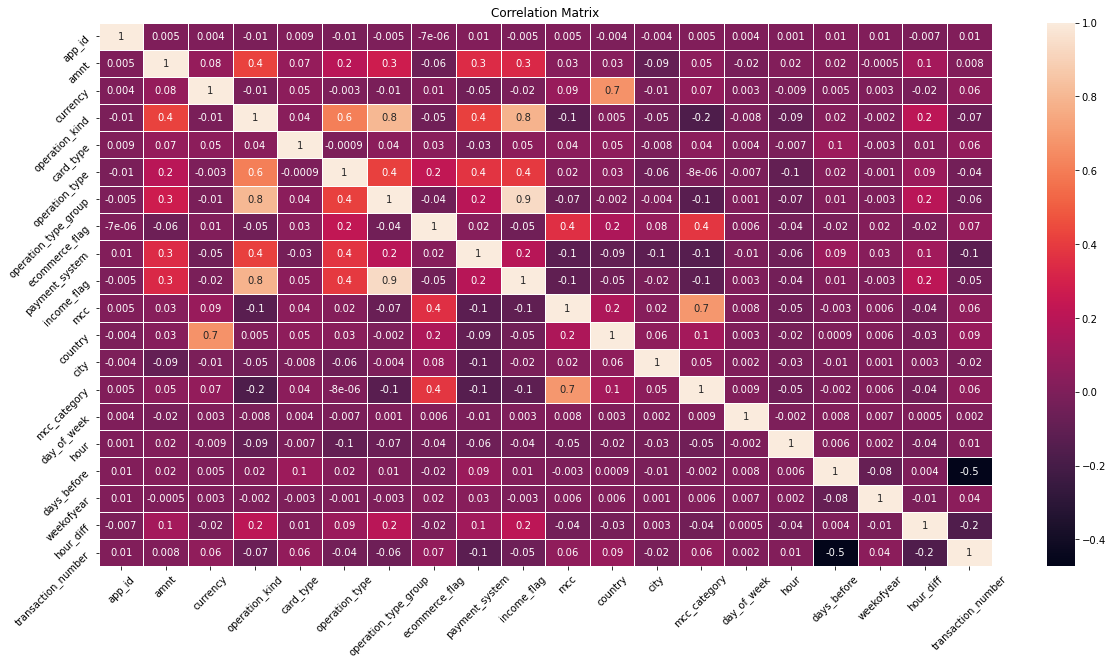

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
attr = [
 'app_id',
 'amnt',
 'currency',
 'operation_kind',
 'card_type',
 'operation_type',
 'operation_type_group',
 'ecommerce_flag',
 'payment_system',
 'income_flag',
 'mcc',
 'country',
 'city',
 'mcc_category',
 'day_of_week',
 'hour',
 'days_before',
 'weekofyear',
 'hour_diff',
 'transaction_number']
ax.set_title("Correlation Matrix")

ax = sns.heatmap(corrmatrix, linewidth=0.5, annot=True, fmt='.1g')
ax.set_xticklabels(attr)
ax.set_yticklabels(attr)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

## Рекомендательная система

In [48]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Создаём рейтинг mcc

In [49]:
df_1 = df["app_id","mcc","day_of_week", "weekofyear"]
df_1.show()

+------+---+-----------+----------+
|app_id|mcc|day_of_week|weekofyear|
+------+---+-----------+----------+
|     0|  2|          4|        34|
|     0|  2|          4|        34|
|     0|  2|          4|        34|
|     0| 10|          2|        34|
|     0|  2|          4|        53|
|     0|  2|          4|        53|
|     0|  2|          2|        53|
|     0|  2|          2|        52|
|     0| 10|          7|        52|
|     0| 10|          7|        52|
|     0|  2|          2|        50|
|     0| 10|          5|        39|
|     0|  2|          3|        39|
|     0|  2|          6|        48|
|     0|  2|          5|        48|
|     0|  9|          5|        48|
|     0|  2|          2|        48|
|     0|  1|          4|        46|
|     0|  2|          4|        46|
|     0|  2|          4|        20|
+------+---+-----------+----------+
only showing top 20 rows



In [50]:
df_1.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)



Ограничиваем данные одним днём

In [51]:
import datetime

now = datetime.datetime.now()

In [52]:
import datetime

now = datetime.datetime.now()
# df_2 = df_1[(df_1["day_of_week"] == now.weekday) & (df_1["weekofyear"] == now.year)]
# print(df_1.filter(col("day_of_week") == now.weekday).collect())

Делаем из 2D таблицы одномерную таблицу признаков

In [53]:
from pyspark.sql.functions import create_map, lit, explode

In [68]:
df_2.show(100)

+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|app_id|   1|   2|   3|   4|   5|   6|   7|   8|   9|  10|  11|  12|  13|  14|  15|  16|  17|  18|  19|  20|  21|  22|  23|  24|  25|  26|  27|  28|  29|  30|  31|  32|  33|  34|  35|  36|  37|  38|  39|  40|  41|  42|  43|  44|  45|  46|  47|  48|  49|  50|  51|  52|  53|  54|  55|  56|  57|  58|  59|  60|  61|  62|  63|  64|  65|  66|  67|  68|  69|  70|  71|  72|  73|  74|  75|  76|  77|  78|  79|  80|  81|  82|  83|  84|  85|  86|  87|  88|  8

In [54]:
df_2 = df_1.groupBy("app_id").pivot("mcc").count()
map_df_2 = (c for x in df_2.columns if x != 'app_id' for c in [lit(x), col(x)])
df_3 = df_2.select('app_id', explode(create_map(*map_df_2))).withColumnRenamed("key","mcc").withColumnRenamed("value","count")
df_3 = df_3.withColumn("mcc", df_3["mcc"].cast(IntegerType()))
df_3.show()

+------+---+-----+
|app_id|mcc|count|
+------+---+-----+
|  7982|  1|   22|
|  7982|  2|    8|
|  7982|  3|   12|
|  7982|  4|    7|
|  7982|  5| null|
|  7982|  6| null|
|  7982|  7| null|
|  7982|  8| null|
|  7982|  9| null|
|  7982| 10|    1|
|  7982| 11| null|
|  7982| 12| null|
|  7982| 13|    1|
|  7982| 14|    1|
|  7982| 15|    2|
|  7982| 16| null|
|  7982| 17| null|
|  7982| 18| null|
|  7982| 19| null|
|  7982| 20| null|
+------+---+-----+
only showing top 20 rows



Делим данные на тестовую и тренировочную выборку и описываем ALS модель

In [55]:
(train, test) = df_3.randomSplit([0.8, 0.2], seed = 1234)

als = ALS(  userCol="app_id", 
            itemCol="mcc",
            ratingCol="count",
            nonnegative = True,
            implicitPrefs = False,
            coldStartStrategy="drop")

# Проверяем создалась ли модель
type(als)

pyspark.ml.recommendation.ALS

Добавляем гиперпараметры в сетку

In [56]:
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

           
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction") 
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


### Build your cross validation pipeline

In [57]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

print(cv)

CrossValidator_63074e572a88


In [58]:
train = train.na.fill(value=0)

Создаём модели и находим лучшую из получившихся

In [59]:
model = cv.fit(train)

best_model = model.bestModel

Выводим параметры лучшей модели

In [60]:
print(type(best_model))

print("Rank:", best_model._java_obj.parent().getRank())
print("MaxIter:", best_model._java_obj.parent().getMaxIter())
print("RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
Rank: 150
MaxIter: 10
RegParam: 0.01


In [61]:
test = test.na.fill(value=0)

In [62]:
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

11.08046839967288


Выводим вероятности следующего mcc(они же предсказания)

In [63]:
test_predictions.show()

+------+---+-----+------------+
|app_id|mcc|count|  prediction|
+------+---+-----+------------+
|    28|  3|    1|    9.706513|
|    28|  6|    0|   3.0021448|
|    28| 18|    0|         0.0|
|    28| 27|    0|   1.4721136|
|    28| 38|    0|  0.41546574|
|    28| 50|    0|  0.14071774|
|    28| 53|    0| 0.016827844|
|    28| 56|    0| 0.015723333|
|    28| 61|    0| 0.009663831|
|    28| 62|    0|0.0021118124|
|    28| 65|    0|  0.13658728|
|    28| 66|    0| 0.034199767|
|    28| 79|    0|  0.36139488|
|    28| 80|    0| 2.450327E-6|
|    28| 82|    0|2.3184177E-5|
|    28| 83|    0|0.0011135808|
|    28| 87|    0|    1.219594|
|    28| 96|    0|  0.06967239|
|    28|108|    0| 0.040622175|
|    31|  7|    0|    2.792789|
+------+---+-----+------------+
only showing top 20 rows



Находим предсказания дальнейших действий(они же рекомендации)

In [64]:
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+------+--------------------+
|app_id|     recommendations|
+------+--------------------+
|    28|[{1, 102.72467}, ...|
|    31|[{2, 62.664986}, ...|
|    34|[{2, 42.85351}, {...|
|    53|[{4, 254.44618}, ...|
|    65|[{1, 285.24442}, ...|
|    78|[{8, 111.8853}, {...|
|    81|[{9, 2.9230669}, ...|
|    85|[{1, 32.980263}, ...|
|   101|[{2, 91.77701}, {...|
|   108|[{1, 251.54924}, ...|
+------+--------------------+

